In [ ]:
!pip install --upgrade tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 46kB/s 
     |████████████████████████████████| 512kB 41.5MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 3.8MB 53.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=4ee3e03f2de0b1e0f8de1f15bba414c67156f9c2e5dbe26b357a36cc532f96e6
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninsta

In [ ]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

#データの読み込み
data= pd.read_csv('/content/drive/MyDrive/house_train.csv')

y = data['SalePrice']
X = data[['GrLivArea', 'YearBuilt']]

# NumPy 配列に変換
X = np.array(X)
y = np.array(y)

#特徴量を正規化
mean_X = X.mean(axis=0)
mean_y = y.mean(axis=0)
std_X = X.std(axis=0)
std_y = y.std(axis=0)
X = (X - mean_X) / std_X
y = (y - mean_y) / std_y
print(X)
print(y)


# ラベルを数値に変換
# y[y == "Iris-versicolor"] = 0
# y[y == "Iris-virginica"] = 1
y = y.astype(np.int64)[:, np.newaxis]

# trainとtestに分割
X_train_house, X_test_house, y_train_house, y_test_house = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train_house, y_train_house, test_size=0.2, random_state=0)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 100
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])


# trainのミニバッチイテレータ
get_mini_batch_train_house = GetMiniBatch(X_train, y_train, batch_size=batch_size)
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    tf.random.set_random_seed(0)
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

[[ 0.37033344  1.05099379]
 [-0.48251191  0.15673371]
 [ 0.51501256  0.9847523 ]
 ...
 [ 1.56964722 -1.00249232]
 [-0.83278768 -0.70440562]
 [-0.49393395 -0.20759447]]
[ 0.34727322  0.00728832  0.53615372 ...  1.07761115 -0.48852299
 -0.42084081]


In [ ]:
# ネットワーク構造の読み込み                               
logits = example_net(X) #Y_predとなる
# 目的関数(損失関数)
# loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
square = tf.square(logits - Y)
loss_op = tf.reduce_mean(square)
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# 推定結果
# correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# variableの初期化
init = tf.global_variables_initializer()
# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    total_loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
        print(epoch)
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int64)
        total_loss = 0
        # total_acc = 0

        
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train_house):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss = sess.run(loss_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
        total_loss /= n_samples
        total_loss_list.append(total_loss)
        val_loss = sess.run(loss_op, feed_dict={X: X_val, Y: y_val})
        val_loss_list.append(val_loss)
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}".format(epoch, total_loss, val_loss))
    # test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    # print("test_acc : {:.3f}".format(test_acc))

0
Epoch 0, loss : 71.5564, val_loss : 106.0325
1
Epoch 1, loss : 8.3973, val_loss : 57.4259
2
Epoch 2, loss : 5.0427, val_loss : 36.4709
3
Epoch 3, loss : 3.3296, val_loss : 23.4646
4
Epoch 4, loss : 2.2281, val_loss : 17.2561
5
Epoch 5, loss : 1.6687, val_loss : 13.9454
6
Epoch 6, loss : 1.3121, val_loss : 11.4124
7
Epoch 7, loss : 1.0538, val_loss : 9.5472
8
Epoch 8, loss : 0.8572, val_loss : 7.9893
9
Epoch 9, loss : 0.7108, val_loss : 6.7333
10
Epoch 10, loss : 0.5999, val_loss : 5.6704
11
Epoch 11, loss : 0.5132, val_loss : 4.8189
12
Epoch 12, loss : 0.4428, val_loss : 4.2021
13
Epoch 13, loss : 0.3908, val_loss : 3.6914
14
Epoch 14, loss : 0.3485, val_loss : 3.3076
15
Epoch 15, loss : 0.3127, val_loss : 2.9906
16
Epoch 16, loss : 0.2829, val_loss : 2.7365
17
Epoch 17, loss : 0.2570, val_loss : 2.5280
18
Epoch 18, loss : 0.2338, val_loss : 2.3394
19
Epoch 19, loss : 0.2141, val_loss : 2.1630
20
Epoch 20, loss : 0.1976, val_loss : 2.0026
21
Epoch 21, loss : 0.1830, val_loss : 1.8580

In [ ]:
print(total_loss_list)

[71.55635674045735, 8.397346548656325, 5.042726414617175, 3.329637587198098, 2.2280723035207908, 1.6686771975339607, 1.3121261153792927, 1.0537829030249308, 0.8572083330001259, 0.7107888564180256, 0.5998977041729513, 0.5132263553602027, 0.44280838340967577, 0.39077463312118416, 0.3485253515794905, 0.31274375137603766, 0.2828690267030381, 0.2569645218216122, 0.23380419414099585, 0.2141227521784045, 0.19756763337511066, 0.1830319744680372, 0.17127036215534047, 0.16107398802833334, 0.15268972441075446, 0.1451780048280763, 0.13872027717833857, 0.13348142407052777, 0.12888322764213897, 0.1243423660399444, 0.12125439833394976, 0.11823677835583177, 0.11575101411699994, 0.11438901943395939, 0.11243029324062631, 0.11025075829833171, 0.10798182869748844, 0.10601409905185281, 0.10396154584638312, 0.10158568323934869, 0.0988312400319081, 0.09543539941055616, 0.09225329525401811, 0.09055857065211527, 0.0875749739018574, 0.08484914218428559, 0.0832632895263921, 0.08124914850313734, 0.081074035939874

In [ ]:
print(val_loss_list)

[106.03246, 57.425896, 36.470917, 23.464605, 17.256102, 13.945408, 11.412378, 9.547156, 7.9893465, 6.7332563, 5.670442, 4.818883, 4.202091, 3.6914144, 3.3076432, 2.990567, 2.7365136, 2.5279853, 2.3394427, 2.1629508, 2.0025716, 1.8579537, 1.7274055, 1.6156005, 1.5128856, 1.4343283, 1.3651979, 1.2991558, 1.2535412, 1.2153819, 1.1835217, 1.1691927, 1.1602994, 1.1387306, 1.1160897, 1.09554, 1.0698558, 1.0502414, 1.0368273, 1.0181495, 1.0078753, 0.9960258, 1.0031451, 0.98705405, 0.97479993, 0.96286273, 0.939521, 0.92885506, 0.92499685, 0.9035116, 0.8745335, 0.87232006, 0.84269243, 0.8398711, 0.8133385, 0.82511586, 0.80530226, 0.7794965, 0.75946313, 0.7482222, 0.7347307, 0.73412836, 0.73848015, 0.74075043, 0.7313608, 0.71651334, 0.7085663, 0.6969564, 0.7105771, 0.70982885, 0.72678787, 0.70643055, 0.7152592, 0.7203139, 0.71044284, 0.71613634, 0.7265453, 0.7136161, 0.7260257, 0.7191137, 0.7356477, 0.7380618, 0.71980095, 0.73127633, 0.71934074, 0.7414702, 0.72468543, 0.71649843, 0.72273797, 0.6

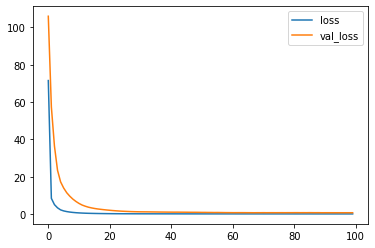

In [ ]:
import matplotlib.pyplot as plt
plt.plot(total_loss_list, label='loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()
plt.show()